# Feature Selection with sklearn and Pandas
https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [2]:
#importing libraries
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#Loading the dataset
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 1. Filter Method:
### most commonly done using Pearson correlation
Here we will first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable MEDV. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.

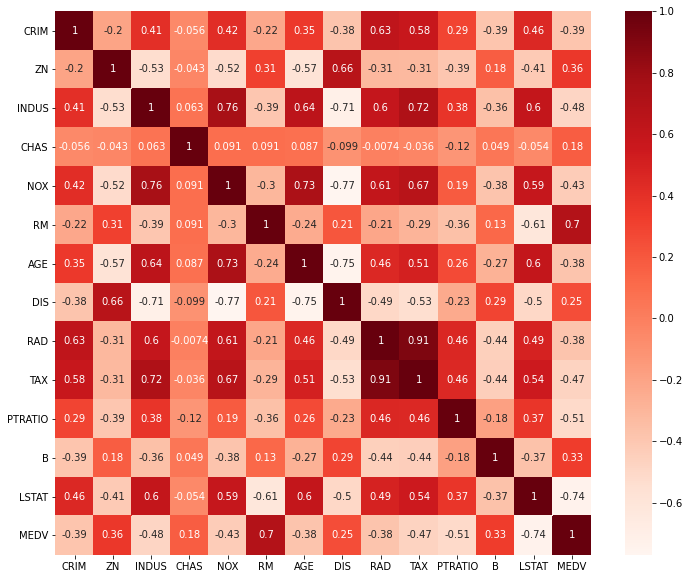

In [3]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
#Correlation with output variable
cor_target = abs(cor["MEDV"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

As we can see, only the features RM, PTRATIO and LSTAT are highly correlated with the output variable MEDV. Hence we will drop all other features apart from these. However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of selected features with each other. This can be done either by visually checking it from the above correlation matrix or from the code snippet below.

In [5]:
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


it is seen that the variables RM and LSTAT are highly correlated with each other (-0.613808). Hence we would keep only one variable and drop the other. We will keep LSTAT since its correlation with MEDV is higher than that of RM.

## 2. Wrapper Method:
A wrapper method needs one machine learning algorithm and uses its performance as evaluation criteria. This means, you feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.
There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE. We will discuss Backward Elimination and RFE here.

### i. Backward Elimination
As the name suggest, we feed all the possible features to the model at first. We check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range. 
The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [8]:
# Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues

const      3.283438e-12
CRIM       1.086810e-03
ZN         7.781097e-04
INDUS      7.382881e-01
CHAS       1.925030e-03
NOX        4.245644e-06
RM         1.979441e-18
AGE        9.582293e-01
DIS        6.013491e-13
RAD        5.070529e-06
TAX        1.111637e-03
PTRATIO    1.308835e-12
B          5.728592e-04
LSTAT      7.776912e-23
dtype: float64

As we can see that the variable ‘AGE’ has highest pvalue of 0.9582293 which is greater than 0.05. Hence we will remove this feature and build the model once again. This is an iterative process and can be performed at once with the help of loop. This approach is implemented below, which would give the final set of variables which are CRIM, ZN, CHAS, NOX, RM, DIS, RAD, TAX, PTRATIO, B and LSTAT

In [9]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


### RFE (Recursive Feature Elimination)
It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [10]:
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True False  True  True False  True False
  True]
[2 4 3 1 1 1 7 1 1 5 1 6 1]


C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [12]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


Optimum number of features: 10
Score with 10 features: 0.663581


C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From ve

As seen from above code, the optimum number of features is 10. We now feed 10 as number of features to RFE and get the final set of features given by RFE method, as follows:

In [13]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


C:\Users\Yael Shushlav\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## 3. Embedded Method
Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.
Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [15]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


In [16]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

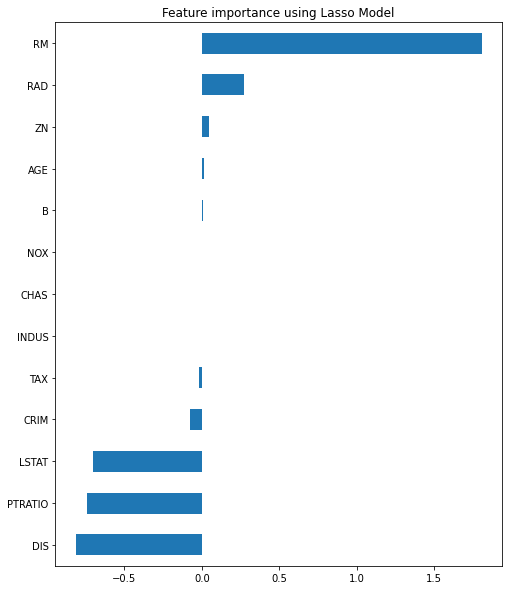

In [17]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Here Lasso model has taken all the features except NOX, CHAS and INDUS.

# Conclusion:
We saw how to select features using multiple methods for Numeric Data and compared their results. Now there arises a confusion of which method to choose in what situation. Following points will help you make this decision.
## 1. Filter method is less accurate. It is great while doing EDA, it can also be used for checking multi co-linearity in data.
## 2. Wrapper and Embedded methods give more accurate results but as they are computationally expensive, these method are suited when you have lesser features (~20).
I